In [1]:
# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import load_img, img_to_array

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

In [2]:
CLASSES = "cats", "dogs"
TRAIN_DIR = Path('./imagenes_tp3_cv/training_set')
TEST_DIR = Path('./imagenes_tp3_cv/test_set')

In [3]:
from PIL import Image
import os, os.path
from collections import Counter


imgs = []
paths = ['./imagenes_tp3_cv/test_set/cats','./imagenes_tp3_cv/test_set/dogs']
valid_images = [".jpg",".gif",".png",".tga"]
for path in paths:
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        imgs.append(Image.open(os.path.join(path,f)))


In [4]:
counter = dict(Counter(getattr(image, 'size') for image in imgs))
counter
c = max(counter, key = lambda x: x[1])
print("Resolución mas frecuente: ", c)
width=64 #c[0]
height=64 #c[1]

Resolución mas frecuente:  (335, 500)


In [5]:
train = image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASSES,
    color_mode="rgb",
    image_size=(width, height),
    shuffle=True,
    seed=14,
)

test = image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASSES,
    color_mode="rgb",
    image_size=(width, height),
    shuffle=True,
    seed=14,
)

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


In [ ]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(CLASSES[np.argmax(labels[i])])
            plt.axis("off")
sample_images(train)

# MLP Simple

In [12]:
model = Sequential([
    Rescaling(1/255, input_shape=(width, height, 3)),
    
    Convolution2D(filters=16, kernel_size=(3, 3), strides=1, activation='relu'),
    Dropout(0.2),
    
    
    Convolution2D(filters=8, kernel_size=(3, 3), strides=1, activation='relu'),
    Dropout(0.2),
    
    
    Convolution2D(filters=8, kernel_size=(3, 3), strides=1, activation='relu'),
    Dropout(0.2),
    
    
    MaxPooling2D(pool_size=(4, 4)),
    # salida de 14x14x8
    
    
    Flatten(),
    
    #Dense(100, activation='tanh'),
    #Dropout(0.2),    
    
    Dense(10, activation='tanh'),
    Dropout(0.2),
        
    Dense(10, activation='tanh'),
    Dropout(0.2),
    
    Dense(len(CLASSES), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

Epoch 1/5
251/251 [==============================] - 28s 111ms/step - loss: 0.5896 - accuracy: 0.6892 - val_loss: 0.5961 - val_accuracy: 0.6767
Epoch 2/5
251/251 [==============================] - 28s 110ms/step - loss: 0.5713 - accuracy: 0.7064 - val_loss: 0.5648 - val_accuracy: 0.7019
Epoch 3/5
251/251 [==============================] - 28s 109ms/step - loss: 0.5497 - accuracy: 0.7265 - val_loss: 0.5727 - val_accuracy: 0.6851
Epoch 4/5
251/251 [==============================] - 28s 109ms/step - loss: 0.5302 - accuracy: 0.7409 - val_loss: 0.5662 - val_accuracy: 0.6975
Epoch 5/5
251/251 [==============================] - 28s 112ms/step - loss: 0.5172 - accuracy: 0.7462 - val_loss: 0.5512 - val_accuracy: 0.7113


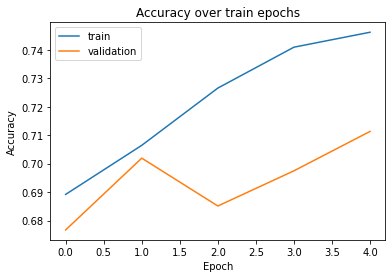

In [14]:
history = model.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=test,
)

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
datasets = (
    ("train", train),
    ("test", test),   
)

for dataset_name, dataset in datasets:
    print('#' * 25, dataset_name, '#' * 25)

    # el dataset se itera en batches, así que calculams predicciones y labels por cada batch, y luego 
    # concatenamos todo
    batches_predictions = []
    batches_labels =  []
    
    for batch_images, batch_labels in dataset:
        # super importante: usamos argmax para convertir cosas de este formato:
        # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
        # a este formato (donde tenemos el índice de la clase que tiene número más alto):
        # [1, 0, 0, 2]
        batches_predictions.append(np.argmax(model.predict(batch_images), axis=-1))
        batches_labels.append(np.argmax(batch_labels, axis=-1))

    predictions = np.concatenate(batches_predictions)
    labels = np.concatenate(batches_labels)
    
    print('accuracy', accuracy_score(labels, predictions))

    # graficamos la confussion matrix
    plt.figure(figsize=(3, 4))
        
    plt.xticks([0, 1], CLASSES, rotation=45)
    plt.yticks([0, 1], CLASSES)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

    plt.imshow(
        confusion_matrix(labels, predictions), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()